### installation der Packages
mamba:

In [1]:
import random as r
import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import geopandas as gpd
import matplotlib.pyplot as plt
from pony.orm import Database, Required, Optional, PrimaryKey, db_session, set_sql_debug, rollback, commit, select, desc, count

### Username und passwort für die Datenbank
Es wird eine Datei credentials.txt benötigt, welche den Username und das Password der PostgreSQL-Datenbank enthält.
In dem folgenden Format:
```txt
username=<username>
password=<password>
```

In [2]:
with open("credentials.txt", "r") as f:
    data = f.read()
data = data.split("\n")
username = data[0].split("=")[1]
password = data[1].split("=")[1]

In [3]:
db = Database()

In [4]:
class Hochschule(db.Entity):
    kurzname = PrimaryKey(str)
    name = Required(str, unique=True)
    typ = Required(str)
    trägerschaft = Required(str)
    anzahl_studierende = Required(int)
    gruendungsjahr = Required(int)
    promotionsrecht = Required(bool)
    habilitationsrecht = Required(bool)
    adresse = Optional("Adresse", reverse="hochschule")

class Adresse(db.Entity):
    hochschule = PrimaryKey("Hochschule", reverse="adresse")
    bundesland = Required(str)
    ort = Required(str)
    straße = Required(str)
    postleitzahl = Required(str)
    homepage = Required(str)
    
class Bevoelkerung(db.Entity):
    id = PrimaryKey(int, auto=True)
    region = Required(str)
    insgesamt = Required(int)
    maennlich = Required(int)
    weiblich = Required(int)
    bev1824 = Optional(float)

In [5]:
db.bind(provider='postgres', user=username, password=password, host='127.0.0.1', database='dbs_project')

In [6]:
set_sql_debug(False)
db.generate_mapping(create_tables=True)

Liest die hochschul Datei ein

In [7]:
pop = pd.read_csv("data/clean_bev.csv", sep="	")
pop = pop[~pop["Insgesamt"].str.contains(r"-") & ~pop["Insgesamt"].str.contains(r"\.")] # contains uses regex
pop.sample(8)

,Region,Insgesamt,männlich,weiblich
261,"Freyung-Grafenau, Landkreis",79286,39459,39827
233,Bayern,13369393,6620203,6749190
102,"Recklinghausen, Kreis",619732,301126,318606
87,"Städteregion Aachen, Kreis",562559,283670,278889
178,"Worms, kreisfreie Stadt",84646,41957,42689
321,"Oberallgäu, Landkreis",158942,78119,80823
207,"Neckar-Odenwald-Kreis, Landkreis",145493,72949,72544
10,"Pinneberg, Kreis",322130,157663,164467


Liest die hochschul Datei ein und entfernt Zeilen die nan enthalten

In [8]:
hoch = pd.read_csv("data/hochschulen.csv", sep=";").dropna(how='any')
hoch.sample(5)

,Hochschulkurzname,Hochschulname,Hochschultyp,Trägerschaft,Bundesland,Anzahl Studierende,Gründungsjahr,Promotionsrecht,Habilitationsrecht,Straße,Postleitzahl (Hausanschrift),Ort (Hausanschrift),Home Page
146,Freiburg EvHS,"Evangelische Hochschule Freiburg, staatlich an...",Fachhochschulen / HAW,"kirchlich, staatlich anerkannt",Baden-Württemberg,898,1971,Nein,Nein,Bugginger Straße 38,79114.0,Freiburg,https://www.eh-freiburg.de
364,Saarbrücken DHfPG,Deutsche Hochschule für Prävention und Gesundh...,Fachhochschulen / HAW,"privat, staatlich anerkannt",Saarland,7133,2001,Nein,Nein,Hermann-Neuberger-Straße 3,66123.0,Saarbrücken,http://www.dhfpg.de
233,Kiel U,Christian-Albrechts-Universität zu Kiel,Universitäten,öffentlich-rechtlich,Schleswig-Holstein,25940,1665,Ja,Ja,Christian-Albrechts-Platz 4,24118.0,Kiel,http://www.uni-kiel.de
29,Berlin BSP,BSP Business and Law School - Hochschule für M...,Fachhochschulen / HAW,"privat, staatlich anerkannt",Berlin,1750,2009,Nein,Nein,Calandrellistraße 1-9,12247.0,Berlin,https://www.businessschool-berlin.de/
285,München HDBW,Hochschule der Bayerischen Wirtschaft für ange...,Fachhochschulen / HAW,"privat, staatlich anerkannt",Bayern,469,2012,Nein,Nein,Konrad-Zuse-Platz 8,81829.0,München,www.hdbw-hochschule.de


In [9]:
#;Bevölkerung 18 bis 24 Jahre (%);
#;;
alt = pd.read_csv("data/K-2022-AI002-2-5--AI0204--2024-06-26.csv", sep=";").dropna(how='any')
alt.sample(5)

,schluessel,regionaleinheit,wert
186,8126,Hohenlohekreis,7.4
48,3405,Wilhelmshaven,7.9
221,8437,Sigmaringen,7.8
101,5766,Lippe,7.3
16,3101,Braunschweig,8.6


Einfügen der Daten

In [10]:
for _, row in pop.iterrows():
    print([row["Region"].split(", ")[0].lstrip()])
    if alt["regionaleinheit"].isin([row["Region"].split(", ")[0].lstrip()]).any():
        np.where(alt["regionaleinheit"] == row["Region"].split(", ")[0].lstrip())[0][0]

['Deutschland']
['Schleswig-Holstein']
['Flensburg']
['Kiel']
['Lübeck']
['Neumünster']
['Dithmarschen']
['Herzogtum Lauenburg']
['Nordfriesland']
['Ostholstein']
['Pinneberg']
['Plön']
['Rendsburg-Eckernförde']
['Schleswig-Flensburg']
['Segeberg']
['Steinburg']
['Stormarn']
['Hamburg']
['Niedersachsen']
['Braunschweig']
['Salzgitter']
['Wolfsburg']
['Gifhorn']
['Goslar']
['Helmstedt']
['Northeim']
['Peine']
['Wolfenbüttel']
['Göttingen']
['Hannover']
['Diepholz']
['Hameln-Pyrmont']
['Hildesheim']
['Holzminden']
['Nienburg (Weser)']
['Schaumburg']
['Celle']
['Cuxhaven']
['Harburg']
['Lüchow-Dannenberg']
['Lüneburg']
['Osterholz']
['Rotenburg (Wümme)']
['Heidekreis']
['Stade']
['Uelzen']
['Verden']
['Weser-Ems']
['Delmenhorst']
['Emden']
['Oldenburg (Oldenburg)']
['Osnabrück']
['Wilhelmshaven']
['Ammerland']
['Aurich']
['Cloppenburg']
['Emsland']
['Friesland']
['Grafschaft Bentheim']
['Leer']
['Oldenburg']
['Vechta']
['Wesermarsch']
['Wittmund']
['Bremen']
['Bremerhaven']
['Nordrhein-We

In [11]:
bevoelkerung_keys = ["region", "insgesamt", "maennlich", "weiblich", "bev1824"]
bevoelkerung_keys_table = ["Region", "Insgesamt", "männlich", "weiblich", "wert"]

for _, row in pop.iterrows():
    # dictionary welches Beim erstellen des Objektes Bevoelkerung übergeben wird
    data_bevoelkerung = dict()
    for i in range(len(bevoelkerung_keys)):
        
        if bevoelkerung_keys[i] == "region":
            data_bevoelkerung[bevoelkerung_keys[i]] = row[bevoelkerung_keys_table[i]].split(", ")[0]
        elif bevoelkerung_keys[i] == "bev1824":
            # Suchen des Wertes von bev1824 mithilfe des Region names
            if alt["regionaleinheit"].isin([row["Region"].split(", ")[0].lstrip()]).any():
                data_bevoelkerung[bevoelkerung_keys[i]] = alt.iloc[np.where(alt["regionaleinheit"] == row["Region"].split(", ")[0].lstrip())[0][0]]["wert"]
        
        else:
            data_bevoelkerung[bevoelkerung_keys[i]] = row[bevoelkerung_keys_table[i]]
    
    # Erstellung eines Zeile in der Datenbank
    Bevoelkerung(**data_bevoelkerung)
# Die hinzugefügten Zeilen werden commited
commit()

In [12]:
hochschule_keys = ["kurzname", "name", "typ", "trägerschaft", "anzahl_studierende", "gruendungsjahr", "promotionsrecht", "habilitationsrecht"]
adresse_keys = ["bundesland", "straße", "postleitzahl", "ort", "homepage"]

hochschule_keys_table = ["Hochschulkurzname", "Hochschulname", "Hochschultyp", "Trägerschaft", "Anzahl Studierende", "Gründungsjahr", "Promotionsrecht", "Habilitationsrecht"]
adresse_keys_table = ["Bundesland", "Straße", "Postleitzahl (Hausanschrift)", "Ort (Hausanschrift)", "Home Page"]
rollback()
for _, row in hoch.iterrows():
    x = dict()
    y = dict()
    for i in range(len(hochschule_keys)):
        x[hochschule_keys[i]] = row[hochschule_keys_table[i]]
    for i in range(len(adresse_keys)):
        if adresse_keys_table[i] == "Postleitzahl (Hausanschrift)":
            # wandelt die postleitzahl die als float gelesen wird in int str um
            if not np.isnan(row[adresse_keys_table[i]]):
                y[adresse_keys[i]] = str(int(row[adresse_keys_table[i]]))
        else:       
            y[adresse_keys[i]] = row[adresse_keys_table[i]]
    hochobject = Hochschule(**x)
    y["hochschule"] = hochobject
    a = Adresse(**y)
    hochobject.adresse = a
commit()
    

***

In [13]:
BUNDELAENDER = ["Mecklenburg-Vorpommern",
                "Thüringen",
                "Sachsen",
                "Schleswig-Holstein",
                "Saarland",
                "Brandenburg",
                "Hessen",
                "Nordrhein-Westfalen",
                "Berlin",
                "Bayern",
                "Bremen",
                "Hamburg",
                "Rheinland-Pfalz",
                "Baden-Württemberg",
                "Sachsen-Anhalt",
                "Niedersachsen"]

SQL Abfrage: Anzahl der Studierenden pro Stadt

In [14]:
def num_studis_stadt(stadt: str) -> int:
    # gibt keinen Fehler wenn stadt nicht existiert
    query = select(sum(h.anzahl_studierende) for h in Hochschule
                    if h.adresse.ort == stadt)
    return query.get()

Test SQL Abfrage: Anzahl der Studierenden pro Stadt

In [15]:
print(num_studis_stadt("Berlin"))
print(num_studis_stadt("München"))
print(num_studis_stadt("Hamburg"))
print(num_studis_stadt("Paris")) # existiert nicht in dem Dataset

190946
131245
107313
0


SQL Abfrage: Verhältnis Anzahl der Studierenden zu Bevölkerung im Bundesland

In [16]:
def ratio_studis_state(state: str) -> float:
    query1 = select(sum(h.anzahl_studierende) for h in Hochschule
                    if h.adresse.bundesland == state)
    if query1.get() == 0:
        # Bundesland existiert nicht
        return 0.0
    query2 = select(sum(b.insgesamt) for b in Bevoelkerung
                    if b.region == state)
    return query1.get()/query2.get()

Test SQL Abfrage: Verhältnis Anzahl der Studierenden zu Bevölkerung im Bundesland

In [17]:
print(ratio_studis_state("Berlin"))
print(ratio_studis_state("Baden-Württemberg"))
print(ratio_studis_state("Hamburg"))
print(ratio_studis_state("München")) # existiert nicht in dem Dataset

0.05084773294781095
0.030706835846027267
0.05671568746624161
0.0


***
### Plotting der Ergebnisse

In [18]:
def num_studis_state(state: str, step, max=100000) -> list:
    query = select(h.anzahl_studierende for h in Hochschule
                    if h.adresse.bundesland == state).sort_by(1)
    max_num_st = query[:][-1]
    num_studis = [i for i in range(0, max_num_st+step, step)]
    
    count_num_studis = [select(num for num in query
                            if num >= value and num < value+step).count()
                                for value in range(0, max_num_st, step)]
        
    return list(zip(num_studis, count_num_studis, [state]*len(num_studis)))

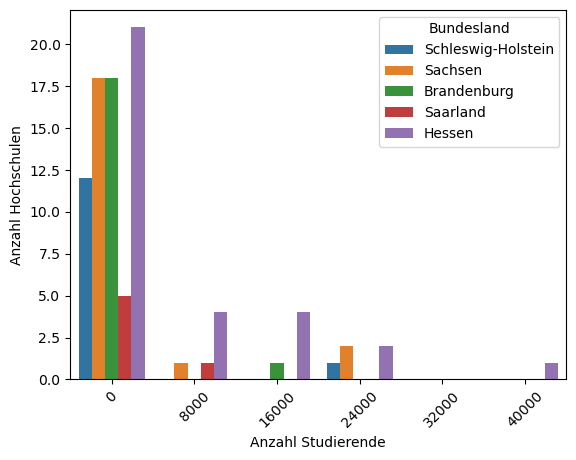

In [19]:
step = 8000

data = []
for b in r.sample(BUNDELAENDER, 5):
    num_studis = num_studis_state(b, step)
    data.append(pd.DataFrame(data=num_studis, columns=["Anzahl Studierende", "Anzahl Hochschulen", "Bundesland"]))

data = pd.concat(data)
ax = sns.barplot(
   data=data, x="Anzahl Studierende", y="Anzahl Hochschulen", hue="Bundesland")
ax.tick_params(axis='x', labelrotation=45)

In [20]:
state = "Thüringen"
query = select((h.name, h.anzahl_studierende) for h in Hochschule
                    if h.adresse.bundesland == state).sort_by(desc(2))[:]
pd.DataFrame(data=query, columns=["name", "anz_studis"])

,name,anz_studis
0,IU Internationale Hochschule,116027
1,Friedrich-Schiller-Universität Jena,16588
2,Universität Erfurt,5795
3,Technische Universität Ilmenau,4452
4,Ernst-Abbe-Hochschule Jena - University of App...,4330
5,Fachhochschule Erfurt,4063
6,Bauhaus-Universität Weimar,3955
7,Hochschule Schmalkalden,2564
8,Hochschule Nordhausen,2035
9,SRH Hochschule für Gesundheit,1434


In [21]:
def num_studis_state2(state: str) -> list:
    # gibt keinen Fehler wenn Bundesland nicht existiert
    query = select(sum(h.anzahl_studierende) for h in Hochschule
                    if h.adresse.bundesland == state)
    num_studis = query.get()
    return num_studis

In [22]:
data = []
for b in BUNDELAENDER:
    data.append((num_studis_state2(b), b))
data = pd.DataFrame(data=data, columns=["Anzahl Studierende", "Bundesland"])

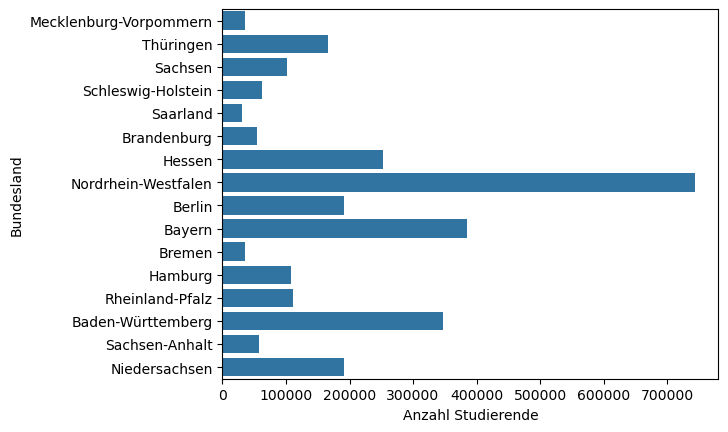

In [23]:
ax = sns.barplot(
   data=data, x="Anzahl Studierende", y="Bundesland")
ax.tick_params(axis='x', labelrotation=0)

In [24]:
data = []
for b in BUNDELAENDER:
    data.append((num_studis_state2(b), ratio_studis_state(b), b))
data = pd.DataFrame(data=data, columns=["Anzahl Studierende tausend", "Verhältnis Studierende/Bevölkerung in %", "Bundesländer"])
data["Verhältnis Studierende/Bevölkerung in %"] *= 100
data["Anzahl Studierende tausend"] /=1000

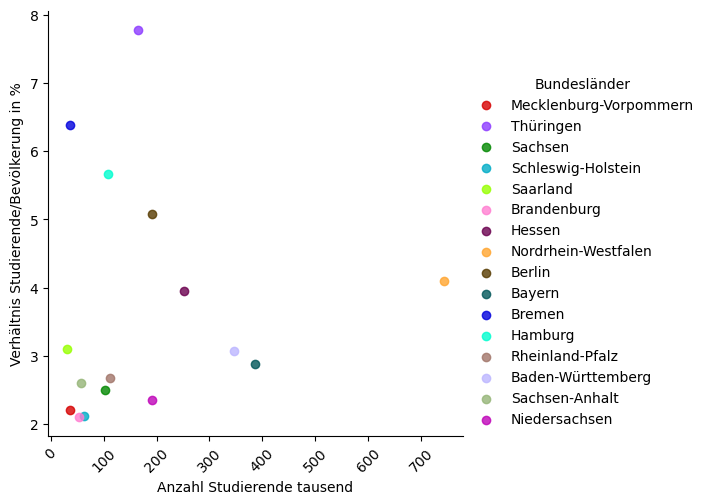

In [25]:
palette = sns.color_palette(cc.glasbey, n_colors=16)
ax = sns.lmplot(
   data=data, x="Anzahl Studierende tausend", y="Verhältnis Studierende/Bevölkerung in %", hue="Bundesländer", palette=palette)
_ = ax.tick_params(axis='x', labelrotation=45)

***

In [26]:
temp0 = select((h.adresse.ort, sum(h.anzahl_studierende)) for h in Hochschule)
temp = select((b.region, sum(b.insgesamt), az) for b in Bevoelkerung for ao, az in temp0 if ao == b.region)

In [27]:

df = pd.DataFrame(data=temp[:], columns=["ort", "gesamt_bevoelkerung", "anzahl_studierende"])
df['verhältnis'] = df['anzahl_studierende'] / df['gesamt_bevoelkerung']
df

,ort,gesamt_bevoelkerung,anzahl_studierende,verhältnis
0,Rosenheim,64403,6648,0.103225
1,Bayreuth,74506,11950,0.160390
2,Aachen,252136,59613,0.236432
3,Neu-Ulm,180425,4077,0.022597
4,Nordhausen,82444,2035,0.024683
...,...,...,...,...
98,Rostock,209920,13245,0.063095
99,Ingolstadt,141029,7537,0.053443
100,Köln,1084831,94017,0.086665
101,Cottbus,99515,6587,0.066191


***
### Sort und Filter Funktion

In [28]:
def get_gesamt_bev_ge(n, sort_by_index=3):
    temp0 = select((h.adresse.ort, sum(h.anzahl_studierende)) for h in Hochschule)
    temp = select((b.region, sum(b.insgesamt), az) for b in Bevoelkerung for ao, az in temp0 if ao == b.region)
    temp = temp.sort_by(desc(sort_by_index))
    return temp.filter(lambda a, b, c: b > n)[:]
pd.DataFrame(data=get_gesamt_bev_ge(100_000), columns=["Ort", "bevoelkerung_insgesammt", "anzahl_studierende"])

,Ort,bevoelkerung_insgesammt,anzahl_studierende
0,Berlin,3755251,190946
1,München,1512491,131245
2,Erfurt,214969,127318
3,Hamburg,1892122,107313
4,Köln,1084831,94017
...,...,...,...
78,Meißen,241343,1035
79,Offenbach,362137,795
80,Gotha,134941,641
81,Detmold,2085331,637


***
### mehr plots

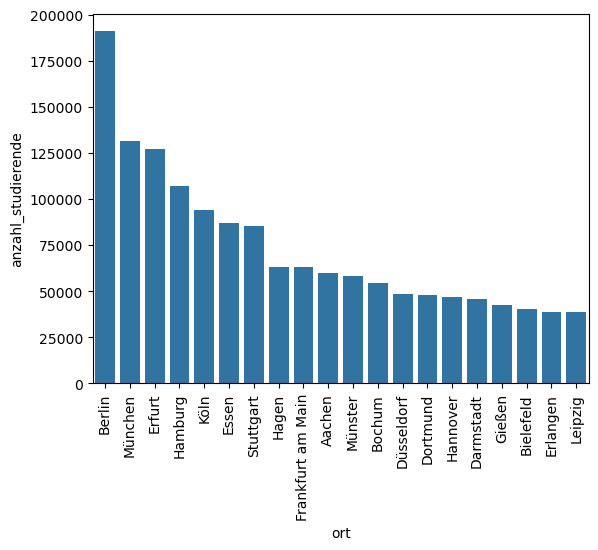

In [29]:
top_studis = df.sort_values(by='anzahl_studierende', ascending=False).head(20)

ax = sns.barplot(data=top_studis, x="ort", y="anzahl_studierende")
ax.tick_params(axis='x', labelrotation=90) 

In [30]:
df.sort_values(by='verhältnis', ascending=False).head(20)

,ort,gesamt_bevoelkerung,anzahl_studierende,verhältnis
35,Erfurt,214969,127318,0.592262
5,Erlangen,116562,38960,0.334243
67,Hagen,189783,63326,0.333676
43,Darmstadt,162243,45730,0.281861
60,Würzburg,127810,35906,0.280933
79,Kaiserslautern,101228,24366,0.240704
74,Heidelberg,162273,38738,0.238721
2,Aachen,252136,59613,0.236432
51,Passau,53907,10881,0.201848
38,Regensburg,157443,31178,0.198027


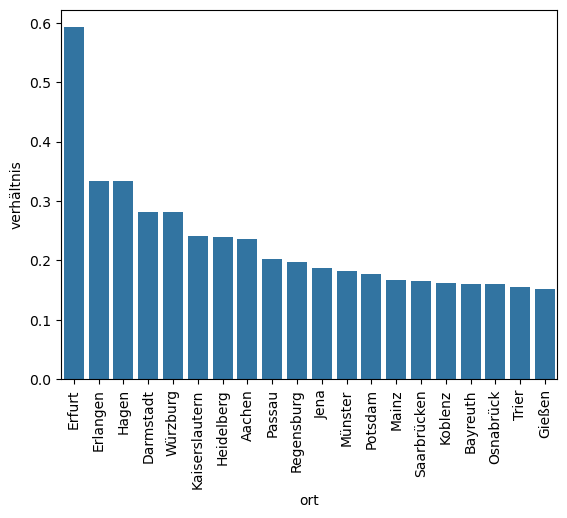

In [31]:
## Verhältnis der Studierenden zur Gesamtbevölkerung
top_verhältnis = df.sort_values(by='verhältnis', ascending=False).head(20)

ax = sns.barplot(data=top_verhältnis, x="ort", y="verhältnis")
ax.tick_params(axis='x', labelrotation=90)  # Drehe 

In [32]:
top_verhältnis.head()

,ort,gesamt_bevoelkerung,anzahl_studierende,verhältnis
35,Erfurt,214969,127318,0.592262
5,Erlangen,116562,38960,0.334243
67,Hagen,189783,63326,0.333676
43,Darmstadt,162243,45730,0.281861
60,Würzburg,127810,35906,0.280933


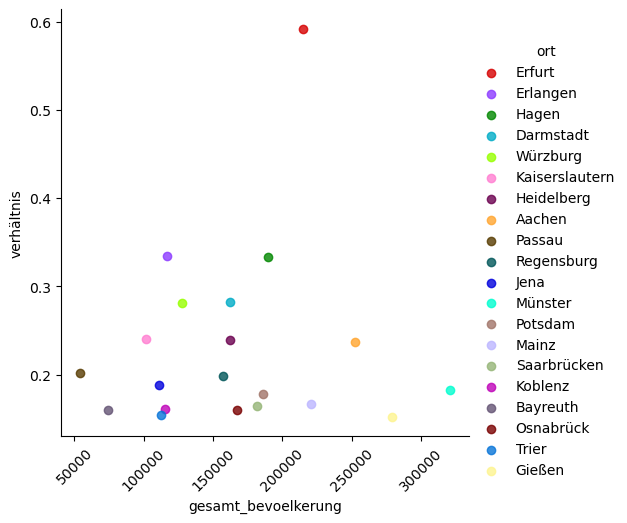

In [33]:
palette = sns.color_palette(cc.glasbey, n_colors=20)
ax = sns.lmplot(
   data=top_verhältnis, x="gesamt_bevoelkerung", y="verhältnis", hue="ort", palette=palette)
_ = ax.tick_params(axis='x', labelrotation=45)

In [34]:
temp = select((b.region, b.bev1824) for b in Bevoelkerung if b.bev1824 != None)[:]
df2 = pd.DataFrame(data=temp, columns=["ort", "bev1824"])
df2

,ort,bev1824
0,Siegen-Wittgenstein,7.7
1,Neu-Ulm,7.6
2,Neustadt a.d.Aisch-Bad Windsheim,7.1
3,Stormarn,6.3
4,Nordwestmecklenburg,5.6
...,...,...
369,Bodenseekreis,6.9
370,Städteregion Aachen,10.3
371,Frankfurt am Main,7.8
372,Leer,7.3


In [35]:
# Shapefile einlesen
deutschland = gpd.read_file('vg2500_geo84/vg2500_krs.shp')

merged = deutschland.merge(df, how='left', left_on='GEN', right_on='ort')
merged2 = deutschland.merge(df2, how='left', left_on='GEN', right_on='ort')

merged.fillna({'verhältnis': 0}, inplace=True)
merged2.fillna({'bev1824': 0}, inplace=True)
merged.fillna({'anzahl_studierende': 0}, inplace=True)

/tmp/ipykernel_481/4158707293.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['ort']):


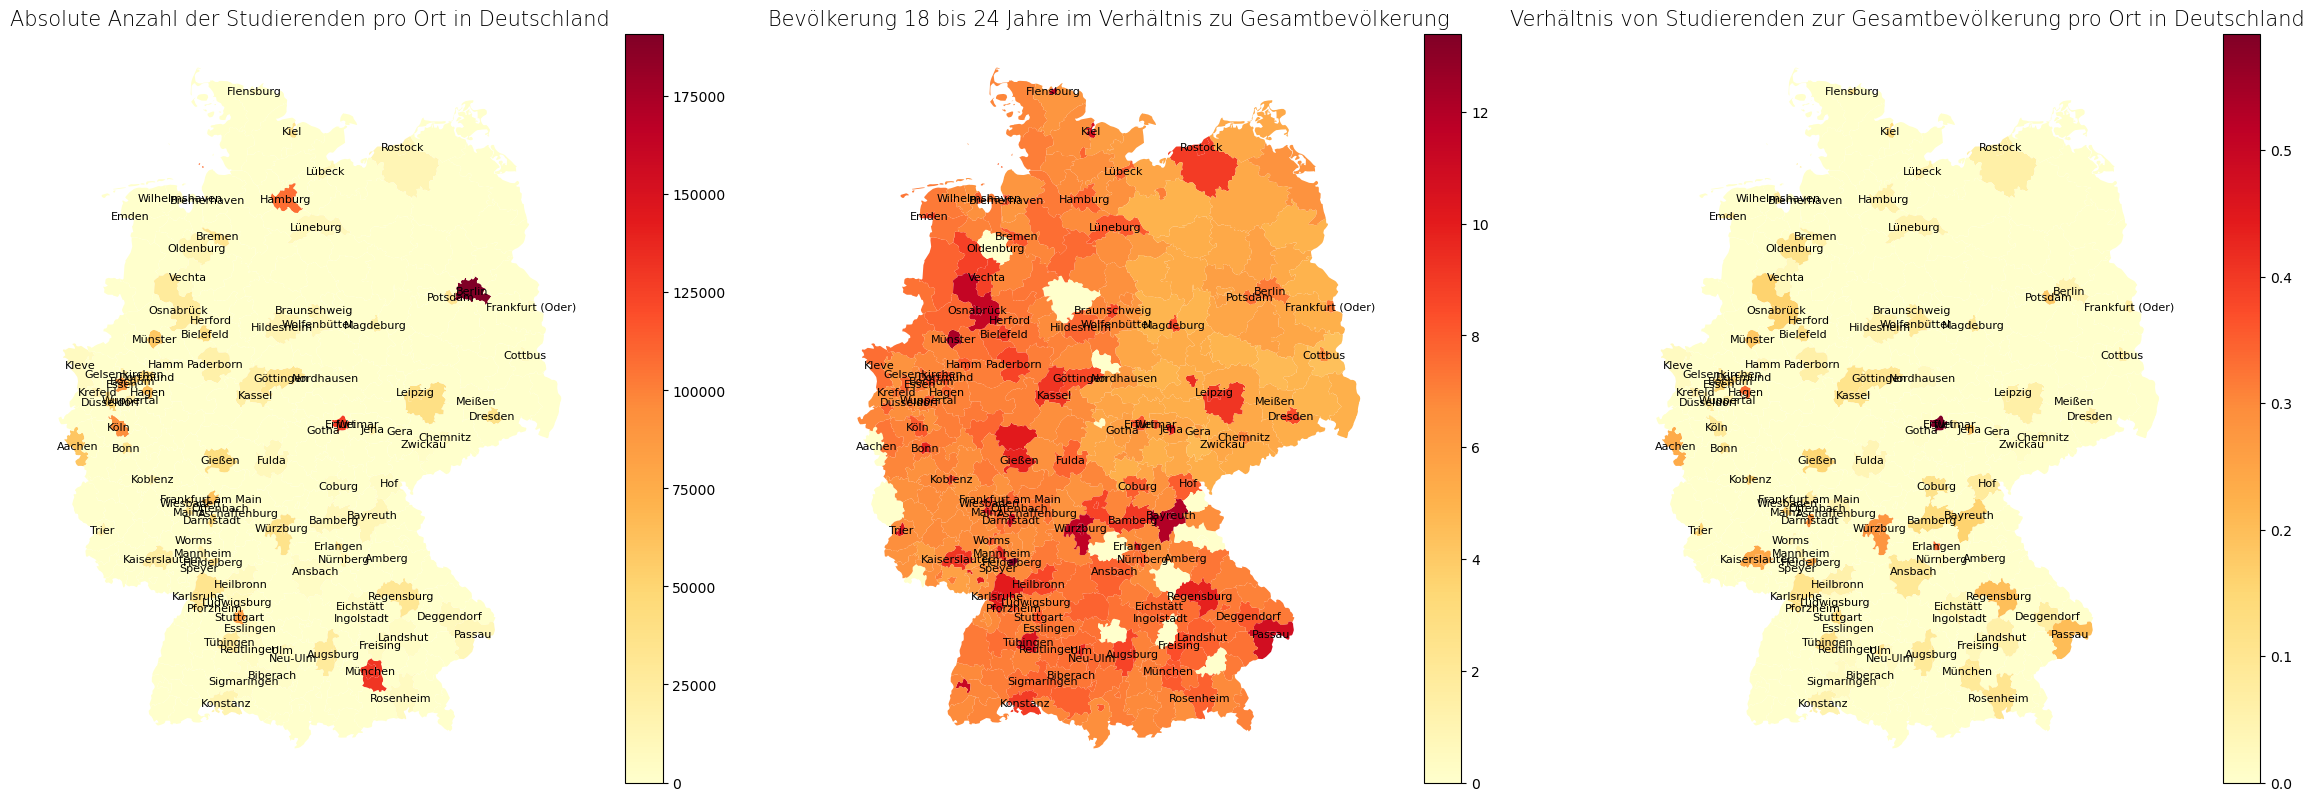

In [36]:
# Plot erstellen
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot für absolute Anzahl der Studierenden
merged.plot(column='anzahl_studierende', cmap='YlOrRd', ax=ax1, legend=True)
ax1.set_title('Absolute Anzahl der Studierenden pro Ort in Deutschland', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax1.axis('off')

# Plot für Verhältnis von Studierenden zur Gesamtbevölkerung
merged2.plot(column='bev1824', cmap='YlOrRd', ax=ax2, legend=True)
ax2.set_title('Bevölkerung 18 bis 24 Jahre im Verhältnis zu Gesamtbevölkerung', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax2.axis('off')

# Plot für Verhältnis von Studierenden zur Gesamtbevölkerung
merged.plot(column='verhältnis', cmap='YlOrRd', ax=ax3, legend=True)
ax3.set_title('Verhältnis von Studierenden zur Gesamtbevölkerung pro Ort in Deutschland', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.axis('off')


# Beschriftung hinzufügen basierend auf dem Verhältnis von Studierenden zur Gesamtbevölkerung
for ax in [ax1, ax2, ax3]:
    already_labeled = []
    for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['ort']):
        if not pd.isna(label) and label not in already_labeled:
            ax.text(x, y, label, fontsize=8, ha='center', va='center')
            already_labeled.append(label)

# Plot anzeigen
plt.tight_layout()
plt.show()

***
### Ausführen wenn es fehler wegen duplikaten gibt

In [37]:
db.drop_all_tables(with_all_data=True)